In [576]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [471]:
cwd = os.getcwd()
print(cwd)
imageFolderPath = 'data/actualData/images/train'
test_imageFolderPath = 'data/actualData/images/test'
labeldCsvFilePath = os.path.join(cwd,'data/actualData/train_labels.csv')
test_labeldCsvFilePath = os.path.join(cwd,'data/actualData/test_labels.csv')

/Users/developementkaha/Documents/Backup_office/Projects/ML/Personal_Practice/TextRecognization


In [472]:
carData = pd.read_csv(labeldCsvFilePath)
test_carData = pd.read_csv(test_labeldCsvFilePath)

In [473]:
carData.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,IMG-20180108-WA0021.jpg,1040,585,plate,478,111,495,119
1,IMG-20180108-WA0021.jpg,1040,585,plate,532,119,548,127
2,IMG-20180108-WA0021.jpg,1040,585,plate,548,117,560,123
3,IMG-20180108-WA0021.jpg,1040,585,plate,437,151,465,161
4,IMG-20180108-WA0021.jpg,1040,585,plate,725,112,737,116


In [474]:
image_size = 128
channel = 3

In [475]:
X_train = []
y_train = np.zeros((len(carData),4))
def extractImages():
    for index,row in carData.iterrows():
        name = row[0]
        x1 = int(row[4])
        y1 = int(row[5])
        x2 = int(row[6])
        y2 = int(row[7])
        path = os.path.join(os.path.join(cwd,imageFolderPath),name)
        img = cv2.imread(path)
        width = img.shape[1]
        height = img.shape[0]
        
        y_train[index,0] = x1* image_size/width
        y_train[index,1] = y1* image_size/height
        y_train[index,2] = (x2-x1)* image_size/width
        y_train[index,3] = (y2-y1)* image_size/height
        X_train.append(path)

In [476]:
extractImages()

In [477]:
X_train[:5]

['/Users/developementkaha/Documents/Backup_office/Projects/ML/Personal_Practice/TextRecognization/data/actualData/images/train/IMG-20180108-WA0021.jpg',
 '/Users/developementkaha/Documents/Backup_office/Projects/ML/Personal_Practice/TextRecognization/data/actualData/images/train/IMG-20180108-WA0021.jpg',
 '/Users/developementkaha/Documents/Backup_office/Projects/ML/Personal_Practice/TextRecognization/data/actualData/images/train/IMG-20180108-WA0021.jpg',
 '/Users/developementkaha/Documents/Backup_office/Projects/ML/Personal_Practice/TextRecognization/data/actualData/images/train/IMG-20180108-WA0021.jpg',
 '/Users/developementkaha/Documents/Backup_office/Projects/ML/Personal_Practice/TextRecognization/data/actualData/images/train/IMG-20180108-WA0021.jpg']

/Users/developementkaha/Documents/Backup_office/Projects/ML/Personal_Practice/TextRecognization/data/actualData/images/train/186.E 6173 IM-11-18.jpeg
[  0.34224599   0.8590604  127.65775401 126.28187919]


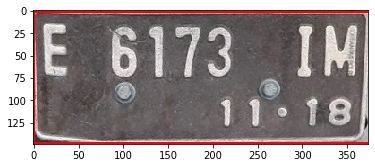

In [478]:
path = X_train[100]
print(path)
regions = y_train[100]
print(regions)
img = cv2.imread(path)
image_height,image_width,_ = img.shape

x1 = int(regions[0] * image_width/image_size)
y1 = int(regions[1] * image_height/image_size)

x2= int((regions[0] + regions[2])  * image_width/image_size)
y2 = int((regions[1] + regions[3]) * image_height/image_size)

fig, ax = plt.subplots(1)
ax.imshow(img)
rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='r',facecolor='none',linestyle='-', linewidth=2)
ax.add_patch(rect)

In [479]:
## Prepare testing data

In [480]:
X_test = []
y_test = np.zeros((len(test_carData),4))
def test_extractImages():
    for index,row in test_carData.iterrows():
        name = row[0]
        x1 = int(row[4])
        y1 = int(row[5])
        x2 = int(row[6])
        y2 = int(row[7])
        path = os.path.join(os.path.join(cwd,test_imageFolderPath),name)
        img = cv2.imread(path)
        width = img.shape[1]
        height = img.shape[0]
        
        y_test[index,0] = x1* image_size/width
        y_test[index,1] = y1* image_size/height
        y_test[index,2] = (x2-x1)* image_size/width
        y_test[index,3] = (y2-y1)* image_size/height
        X_test.append(path)

In [481]:
test_extractImages()

In [482]:
from tensorflow.keras.applications.mobilenet import MobileNet
from tensorflow.keras.applications.mobilenet import preprocess_input
# from tensorflow.keras.applications.resnet_v2 import ResNet152V2
# from tensorflow.keras.applications.resnet_v2 import preprocess_input
from PIL import Image
from tensorflow.keras.layers import Dense,Reshape,Conv2D,Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow import py_function
import tensorflow 

In [483]:
for i,f in enumerate(X_train):
    img = Image.open(f)
    img = img.resize((image_size, image_size)) # Resize image
    img = img.convert('RGB')

    X_train[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
    img.close()

In [484]:
X_train = np.array(X_train)

In [485]:
for i,f in enumerate(X_test):
    img = Image.open(f)
    img = img.resize((image_size, image_size)) # Resize image
    img = img.convert('RGB')

    X_test[i] = preprocess_input(np.array(img, dtype=np.float32)) # Convert to float32 array
    img.close()

X_test = np.array(X_test)

In [486]:
X_test.shape,y_test.shape

((60, 128, 128, 3), (60, 4))

In [487]:
## Build model

In [488]:
def createModel(trainBaseModel=True):
    inputShape = (image_size,image_size,channel)
    alpha = 1.0
#     basemodel = ResNet152V2(input_shape=inputShape,include_top=False,weights='imagenet')
    basemodel = MobileNet(input_shape=inputShape,include_top=False,alpha=alpha)
#     
    for layer in basemodel.layers:
        layer.trainable = trainBaseModel
    
    basemodel_output = basemodel.layers[-1].output
#     basemodel.summary()
    x1 = Conv2D(4, kernel_size=4, name="coords")(basemodel_output)
#     # In the line above kernel size should be 3 for img size 96, 4 for img size 128, 5 for img size 160 etc.
    output = Reshape((4,))(x1)
#     flat = Flatten()(x1)
#     dense = Dense(1024,activation='linear',name='MJ_1_layer')(flat)
#     output = Dense(4,activation='linear',name='output')(flat)
    return Model(inputs=basemodel.input, outputs=output)

In [489]:
model = createModel(False)

In [490]:
model.summary()

Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 128, 128, 3)]     0         
_________________________________________________________________
conv1_pad (ZeroPadding2D)    (None, 129, 129, 3)       0         
_________________________________________________________________
conv1 (Conv2D)               (None, 64, 64, 32)        864       
_________________________________________________________________
conv1_bn (BatchNormalization (None, 64, 64, 32)        128       
_________________________________________________________________
conv1_relu (ReLU)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv_dw_1 (DepthwiseConv2D)  (None, 64, 64, 32)        288       
_________________________________________________________________
conv_dw_1_bn (BatchNormaliza (None, 64, 64, 32)        128 

In [491]:
def IOU(y_true, y_pred):
    intersections = 0
    unions = 0
    # set the types so we are sure what type we are using

    gt = y_true
    pred = y_pred
    # Compute interection of predicted (pred) and ground truth (gt) bounding boxes
    diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
    diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
    intersection = diff_width * diff_height

    # Compute union
    area_gt = gt[:,2] * gt[:,3]
    area_pred = pred[:,2] * pred[:,3]
    union = area_gt + area_pred - intersection

    # Compute intersection and union over multiple boxes
    for j, _ in enumerate(union):
        if union[j] > 0 and intersection[j] > 0 and union[j] >= intersection[j]:
            intersections += intersection[j]
            unions += union[j]

    # Compute IOU. Use epsilon to prevent division by zero
    iou = np.round(intersections / (unions + tensorflow.keras.backend.epsilon()), 4)
    # This must match the type used in py_func
    iou = iou.astype(np.float32)
    return iou

In [492]:
def IoU(y_true, y_pred):
    iou = py_function(IOU, [y_true, y_pred], Tout=tensorflow.float32)
    return iou

In [493]:
model.compile(loss="mean_squared_error", optimizer="adam", metrics=[IoU]) # Regression loss is MSE

In [494]:
# Use earlystopping
callback = EarlyStopping(monitor='val_IoU', patience=5, min_delta=0.01)

# Fit the model
model.fit(X_train,y_train, validation_data=(X_test,y_test), epochs=10, batch_size=32, callbacks=[callback])

Epoch 1/10
21/21 [==============================] - 11s 542ms/step - loss: 1644.4122 - IoU: 0.3800 - val_loss: 451.8470 - val_IoU: 0.7163
Epoch 2/10
21/21 [==============================] - 10s 500ms/step - loss: 408.5561 - IoU: 0.7179 - val_loss: 389.5312 - val_IoU: 0.7625
Epoch 3/10
21/21 [==============================] - 11s 513ms/step - loss: 269.0307 - IoU: 0.7913 - val_loss: 341.3103 - val_IoU: 0.7880
Epoch 4/10
21/21 [==============================] - 13s 620ms/step - loss: 224.0456 - IoU: 0.8275 - val_loss: 336.7777 - val_IoU: 0.8093
Epoch 5/10
21/21 [==============================] - 12s 554ms/step - loss: 196.4053 - IoU: 0.8423 - val_loss: 356.4239 - val_IoU: 0.7915
Epoch 6/10
21/21 [==============================] - 12s 548ms/step - loss: 183.4088 - IoU: 0.8432 - val_loss: 389.4782 - val_IoU: 0.8113


In [495]:
model.evaluate(X_test,y_test)

2/2 [==============================] - 0s 217ms/step - loss: 389.4782 - IoU: 0.8113


[389.4782409667969, 0.8113499879837036]

In [496]:
# Test model

In [775]:
import pytesseract

In [832]:
def preditction(imagename):
    cwd = os.getcwd()
#     print(cwd)
    imageFolderPath = 'Car_number_plate'

    filepath = os.path.join(os.path.join(cwd,imageFolderPath),imagename)
#     print(filepath)

    unscaled = cv2.imread(filepath)
    image_height, image_width, _ = unscaled.shape
    image = cv2.resize(unscaled, (image_size, image_size)) # Rescaled image to run the network
    feat_scaled = preprocess_input(np.array(image, dtype=np.float32))
#     print ("Size of original input: ", image.shape)
#     print("-------------------------------")
#     print("Size of scaled input: ", feat_scaled.shape)

    region = model.predict(x=np.array([feat_scaled]))[0]

    print(region)

    x1 = int(region[0] * image_width/image_size)
    y1 = int(region[1] * image_height/image_size)

    x2= int((region[0] + region[2])  * image_width/image_size)
    y2 = int((region[1] + region[3]) * image_height/image_size)

    fig, ax = plt.subplots(1)
    ax.imshow(unscaled)
    rect = patches.Rectangle((x1,y1),x2-x1,y2-y1,edgecolor='r',facecolor='none',linestyle='-', linewidth=2)
    ax.add_patch(rect)


    x1, y1, x2,y2

    img_cv = cv2.cvtColor(unscaled, cv2.COLOR_BGR2RGB)
    r = unscaled[y1:y2,x1:x2]
    plt.imshow(r)

    conf = f'--oem 3 --psm 9 outputbase alphanumeric'
    # print(conf)
    configuration = (conf)
    text = pytesseract.image_to_string(r, config=configuration)
    print('Detected text: '+text)
#     print('done')

[24.13946  22.928036 80.67579  78.191826]
Detected text: _


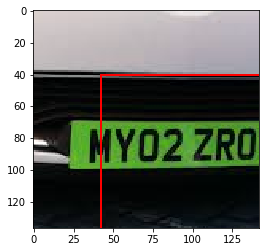

In [833]:
preditction('images_34.jpg')

In [824]:
# text = pytesseract.image_to_string(unscaled, config=configuration)

In [634]:
# text

'?mlm:'

In [605]:
# model.save('numberPlate_textRecog.h5')
# model.save_weights('numberPlate_textRecog_weights.h5')